# Exploratory Data Analysis

# Imports, Read-in

In [82]:
# Data manip.
import pandas as pd
import numpy as np

# Vizz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# scikit-learn
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
sw = stopwords.words('english')

# etc.
import sys
sys.path.append( '../src' )
from xgboost import XGBClassifier, XGBRFClassifier
from parse_it import get_wordnet_pos, parse_doc
from pretty_results import *

The data is stored in two separate `.csv` files.

In [48]:
df_good = pd.read_csv('../../data/good.csv')
df_promo = pd.read_csv('../../data/promotional.csv')

Taking a look at a sample article from the `good` articles dataset.

In [49]:
df_good.iloc[138].text

"The 8th Military Police Brigade is a military police brigade of the United States Army based at Schofield Barracks, Hawaii. It is responsible for Army military police units within the United States Indo Pacific Command Area of Responsibility. Activated during the Vietnam War, the 8th Military Police Brigade was specifically organized to provide planning, direction, and supervision for the criminal investigation work required by the U.S. Army in Vietnam. It replaced a provisional Military Police Group Criminal Investigation that had been formed on 3 November 1966 in charge of all criminal investigative work in Vietnam, except for the metropolitan Saigon area. In July 1972, it became the basis for the U.S. Army Criminal Investigation Center, Vietnam Field Office. It served in the region for several years and earning ten campaign streamers before being deactivated during the American forces pullout from the region. The brigade was reactivated in Korea in the 1980s to provide command and 

Testing out a custom function, `parse_doc`, which takes care of several NLP preprocessing steps: lowercasing, punctuation and character stripping, lemmatizing, and removing stopwords. It returns a string of *non-unique lemmas*, but can also return a list by setting the argument `as_list = True`. If stemming is preferred to lemmatizing, this can also be done within the function: `stem = 'stem'`.

In [50]:
parse_doc( df_good.iloc[138].text )

'th military police brigade military police brigade united state army base schofield barrack hawaii responsible army military police unit within united state indo pacific command area responsibility activate vietnam war th military police brigade specifically organize provide plan direction supervision criminal investigation work require u army vietnam replace provisional military police group criminal investigation form november charge criminal investigative work vietnam except metropolitan saigon area july become basis u army criminal investigation center vietnam field office serve region several year earn ten campaign streamer deactivate american force pullout region brigade reactivate korea provide command control u pacific military police force since move hawaii much u army pacific locate brigade subordinate unit u army pacific eighth theater sustainment command fall direct command th theater sustainment command currently th military police brigade consist two battalion rd explosi

And, just to get the lay of the land, a look at one of the `promotional` articles.

In [51]:
df_promo.iloc[138].text

'Susan Abrams born 1964 is an American business executive who is the Chief Executive Officer of the Illinois Holocaust Museum and Education Center. Abrams was born in New York City and attended the University of Pennsylvania, graduating in 1986 from the Wharton School summa cum laude. Abrams went on to get her Master of Management from Kellogg Graduate School of Management at Northwestern University. Abrams has served on the Chicago Childrens Museum Board of directors as well as the Board of Advisors for the Womens Business Association and Center for Nonprofit Management at Kellogg School of Management. After graduation, Abrams became a financial analyst at Goldman Sachs and, later, a management consultant at McKinsey Company. After McKinsey, Abrams took the position of Vice President of Business, Strategic Planning, Marketing and Communications at the Chicago Childrens Museum. In 1997, Abrams left the Chicago Childrens Museum. Three years later, she published The New Success Rules for

In [52]:
parse_doc(df_promo.iloc[138].text)

'susan abrams bear american business executive chief executive officer illinois holocaust museum education center abrams born new york city attend university pennsylvania graduate wharton school summa cum laude abrams go get master management kellogg graduate school management northwestern university abrams serve chicago childrens museum board director well board advisor womens business association center nonprofit management kellogg school management graduation abrams become financial analyst goldman sachs later management consultant mckinsey company mckinsey abrams take position vice president business strategic planning marketing communication chicago childrens museum abrams leave chicago childrens museum three year later publish new success rule woman surefire strategy reach career goal found residential real estate company abrams become director program review northwestern university two year abrams move become coo jcc chicago since abrams ceo illinois holocaust museum education c

# Sample Size, Scope, and Content

In [7]:
print(df_good.shape)
print(df_promo.shape)

(30279, 2)
(23837, 7)


In [8]:
df_good.shape[0] + df_promo.shape[0]

54116

In terms of **rows/records**,
- The dataframe containing **"good"** articles has 30,279 entries.
- The dataframe containing **"promotional"** articles has 23,837 entries.

Combined, we have **54,116** articles for examination.

Next, let's discuss features/columns.

In [9]:
print(df_good.columns)
print(df_promo.columns)

Index(['text', 'url'], dtype='object')
Index(['text', 'advert', 'coi', 'fanpov', 'pr', 'resume', 'url'], dtype='object')


- The dataframe containing **"good"** articles has 2 columns - `text` and `url`.
- The dataframe containing **"promotional"** articles has 7 columns - in addition to `text` and `url`, there are five subtypes of "promotional tone":

    - `advert`: The article reads like an advertisement.
    - `coi`: The article appears to have been written by someone with a close connection to the subject.
    - `fanpov`: The article appears to have been written from a fan's point of view, rather than a neutral point of view.
    - `pr`: The article reads like a press release/news article.
    - `resume`: The (biographical) article reads like a résumé, i.e. it is neither neutral nor encylopedic in nature.
    
    The values contained in these columns are one-hot encoded binary values. See the dataframe heads below for a tabular representation of the data.

In [10]:
df_good.head(3)

,text,url
0,Nycticebus linglom is a fossil strepsirrhine p...,https://en.wikipedia.org/wiki/%3F%20Nycticebus...
1,Oryzomys pliocaenicus is a fossil rodent from ...,https://en.wikipedia.org/wiki/%3F%20Oryzomys%2...
2,.hack dt hk is a series of single player actio...,https://en.wikipedia.org/wiki/.hack%20%28video...


In [11]:
df_promo.head(3)

,text,advert,coi,fanpov,pr,resume,url
0,"1 Litre no Namida 1, lit. 1 Litre of Tears als...",0,0,1,0,0,https://en.wikipedia.org/wiki/1%20Litre%20no%2...
1,"1DayLater was free, web based software that wa...",1,1,0,0,0,https://en.wikipedia.org/wiki/1DayLater
2,1E is a privately owned IT software and servic...,1,0,0,0,0,https://en.wikipedia.org/wiki/1E


### Side Investigation: Average Length of Articles?

While reading in the data, I noticed that the `promotional` article I selected at semi-random was considerably shorter than the semi-random `good` article - I had to wonder if this observation held true at all in the rest of the dataset and decided to investigate average article length for each class.

`len()` can give us a count of characters - `split()` must be used to get a word count.

In [12]:
print(f"Character count in first 'good' article: {len(df_good.iloc[0].text)}")
print(f"Word count in first 'good' article: {len(df_good.iloc[0].text.split())}")

Character count in first 'good' article: 3466
Word count in first 'good' article: 590


We can use string methods on the dataframes by calling `.str` - this makes calculations a lot easier.

In [13]:
df_good.text.str.len()

0         3466
1         3230
2        22691
3         5620
4         9303
         ...  
30274    32625
30275     6667
30276     9625
30277    15576
30278    11186
Name: text, Length: 30279, dtype: int64

In [14]:
df_promo.text.str.len()

0         3439
1         1546
2         5550
3        11461
4         1300
         ...  
23832      895
23833     2677
23834     1306
23835     4642
23836     2946
Name: text, Length: 23837, dtype: int64

In [15]:
avg_char_good = df_good.text.str.len().mean()
avg_char_promo = df_promo.text.str.len().mean()

In [16]:
split_words_good = df_good.text.str.split()
split_words_promo = df_promo.text.str.split()

In [17]:
word_count_good = 0

for article in split_words_good:
    word_count_good += len(article)
    
avg_words_good = word_count_good / len(split_words_good)

print(avg_words_good)

2628.5815581756333


In [18]:
word_count_promo = 0

for article in split_words_promo:
    word_count_promo += len(article)
    
avg_words_promo = word_count_promo / len(split_words_promo)

print(avg_words_promo)

768.2722658052608


In [19]:
print(f"Average 'good' article length: {avg_char_good:.0f} characters, {avg_words_good:.0f} words")
print(f"Average 'promotional' article length: {avg_char_promo:.0f} characters, {avg_words_promo:.0f} words\n")
print(f"Rough calc of characters per word, 'good' articles: {(avg_char_good / avg_words_good):.2f}")
print(f"Rough calc of characters per word, 'promotional' articles: {(avg_char_promo / avg_words_promo):.2f}\n")
print(f"On average, 'good' articles are {(avg_words_good / avg_words_promo):.1f} times longer than 'promotional' articles")

Average 'good' article length: 15649 characters, 2629 words
Average 'promotional' article length: 4771 characters, 768 words

Rough calc of characters per word, 'good' articles: 5.95
Rough calc of characters per word, 'promotional' articles: 6.21

On average, 'good' articles are 3.4 times longer than 'promotional' articles


In [41]:
plt.style.use('seaborn-dark')

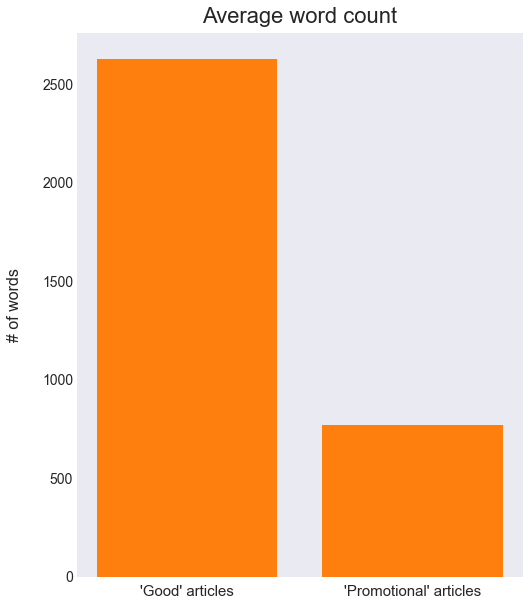

In [78]:
# Visualization of average lengths
fig, ax = plt.subplots(figsize=(8, 10))

plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
ax.tick_params(axis='x', which='major', pad=8)

ax.bar(x=["'Good' articles", "'Promotional' articles"],
       height=(avg_words_good, avg_words_promo),
       color=['tab:orange'])

ax.set_title("Average word count",
             pad=10,
             fontsize=22)
ax.set_ylabel("# of words",
              labelpad=20,
              fontsize=16)

fig.savefig(fname='../images/avg_word_count.png',
            dpi=600,
            bbox_inches='tight')

## Checking for Nulls / Data Types

In [20]:
df_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30279 entries, 0 to 30278
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30279 non-null  object
 1   url     30279 non-null  object
dtypes: object(2)
memory usage: 473.2+ KB


In [21]:
df_promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23837 entries, 0 to 23836
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23837 non-null  object
 1   advert  23837 non-null  int64 
 2   coi     23837 non-null  int64 
 3   fanpov  23837 non-null  int64 
 4   pr      23837 non-null  int64 
 5   resume  23837 non-null  int64 
 6   url     23837 non-null  object
dtypes: int64(5), object(2)
memory usage: 1.3+ MB


## Value Counts for Subclasses

Knowing there are five different subtypes of promotional article indicated within the dataset raises a further question: *how are those subtypes distributed?*

In [22]:
df_promo.select_dtypes(include='number').columns

Index(['advert', 'coi', 'fanpov', 'pr', 'resume'], dtype='object')

In [23]:
# class_cols = df_promo.select_dtypes(include='number').columns
class_cols = df_promo.select_dtypes(include='number').columns.tolist()

class_cols

['advert', 'coi', 'fanpov', 'pr', 'resume']

In [24]:
for col in class_cols:
    print(f"{df_promo[[col]].value_counts(normalize=True)}\n")

advert
1         0.793346
0         0.206654
dtype: float64

coi
0      0.91014
1      0.08986
dtype: float64

fanpov
0         0.93724
1         0.06276
dtype: float64

pr
0     0.936401
1     0.063599
dtype: float64

resume
0         0.90779
1         0.09221
dtype: float64



In [25]:
advert_posi = df_promo.advert.value_counts(normalize=True).values[0]
coi_posi = df_promo.coi.value_counts(normalize=True).values[1]
fanpov_posi = df_promo.fanpov.value_counts(normalize=True).values[1]
pr_posi = df_promo.pr.value_counts(normalize=True).values[1]
resume_posi = df_promo.resume.value_counts(normalize=True).values[1]

posi_counts = [advert_posi, coi_posi, fanpov_posi, pr_posi, resume_posi]

posi_counts

[0.7933464781641986,
 0.08986030121240089,
 0.06275957544993079,
 0.06359860720728279,
 0.09220959013298653]

In [26]:
df_promo.columns

Index(['text', 'advert', 'coi', 'fanpov', 'pr', 'resume', 'url'], dtype='object')

In [27]:
# fig, ax = plt.subplots(nrows=1,
#                        ncols=5,
#                        figsize=(30,6),
#                        sharey='all')

# ax[0].bar(x=df_promo['advert'].value_counts(normalize=True).index,
#           height=df_promo['advert'].value_counts(normalize=True).values,
#           tick_label=['True', 'False'])
# ax[0].set_title("Advertisement-like")

# ax[1].bar(x=df_promo['coi'].value_counts(normalize=True).index,
#           height=df_promo['coi'].value_counts(normalize=True).values,
#           tick_label=['False', 'True'])
# ax[1].set_title("Conflict of interest")

# ax[2].bar(x=df_promo['fanpov'].value_counts(normalize=True).index,
#           height=df_promo['fanpov'].value_counts(normalize=True).values,
#           tick_label=['False', 'True'])
# ax[2].set_title("Written from fan's point of view")

# ax[3].bar(x=df_promo['pr'].value_counts(normalize=True).index,
#           height=df_promo['pr'].value_counts(normalize=True).values,
#           tick_label=['False', 'True'])
# ax[3].set_title("Written like a news article/press release")

# ax[4].bar(x=df_promo['resume'].value_counts(normalize=True).index,
#           height=df_promo['resume'].value_counts(normalize=True).values,
#           tick_label=['False', 'True'])
# ax[4].set_title("Reads like a résumé");

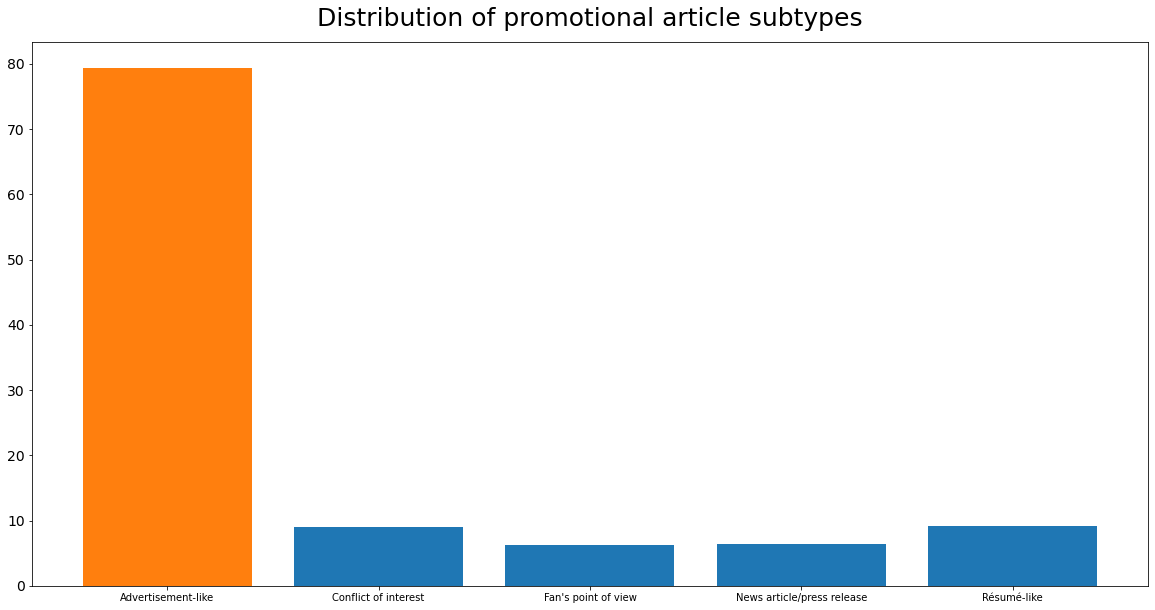

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))

y_ticks = np.linspace(0, 0.8, 9)
y_tick_labels = []

for x in np.linspace(0, 80, 9).tolist():
    x = str(x).replace('.0', '')
    y_tick_labels.append(x)

ax.bar(x=["Advertisement-like",
          "Conflict of interest",
          "Fan's point of view",
          "News article/press release",
          "Résumé-like"],
       height=posi_counts,
       color=['tab:orange', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue'])

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels,
                   fontsize=14)
ax.set_title("Distribution of promotional article subtypes",
             fontsize=25,
             pad=16);

# Set-up for Simple Binary Classification

First, we drop all columns but `text`, which will be our primary feature.

In [30]:
df_good = df_good[['text']]
df_promo = df_promo[['text']]

Before concatening the simplified dataframes, I create a new column `label` in each dataframe and give it the same value in every row. In `df_good`, each row is given the label `0` to indicate `False`, i.e. the article does ***not*** have a promotional tone. Conversely, each row in `df_promo` is given the label `1` to represent `True`, that the article ***does*** contain content that is promotional in tone.

Multi-class classification is explored in a [separate notebook](Multi-label.ipynb).

In [31]:
df_good['label'] = 0
df_good.head(3)

,text,label
0,Nycticebus linglom is a fossil strepsirrhine p...,0
1,Oryzomys pliocaenicus is a fossil rodent from ...,0
2,.hack dt hk is a series of single player actio...,0


In [ ]:
df_promo['label'] = 1
df_promo.head(3)

Next, we concatenate the dataframes using the pandas method `.append` - setting `ignore_index` to `True` means that the unique index values from `df_promo` are not carried over when this dataframe is appended to `df_good`; the indexing, rather, continues where `df_good`'s index leaves off.

In [ ]:
df = df_good.append(other=df_promo,
                    ignore_index=True)

df

In [ ]:
# df = df.sample(frac = 1).reset_index(drop=True)

# df

In [ ]:
# freq_out(df, 'text', 10)

In [ ]:
# df['text_lem'] = df['text'].apply(parse_doc) 

In [ ]:
# df.to_csv('lemmed_combined.csv')

## Reading in Newly Created csv file (with lemmas)

In [53]:
lemmed_df = pd.read_csv('../../data/lemmed_combined.csv', index_col=0)

In [54]:
lemmed_df.head(3)

,text,label,text_lem
0,"Ryan Steven Lochte lkti LOK tee born August 3,...",0,ryan steven lochte lkti lok tee bear august am...
1,CAM ships were World War II era British mercha...,0,cam ship world war ii era british merchant shi...
2,The politics of Vietnam are defined by a singl...,0,politics vietnam define single party socialist...


In [ ]:
additional_sw = ['january',
                 'february',
                 'april', # 'march' and 'may' are English verbs and
                          #  are thus excluded
                 'june',
                 'july',
                 'august',
                 'september',
                 'october',
                 'november',
                 'december']

# Modeling Setup/Brainstorming

In [55]:
X = lemmed_df['text_lem']
y = lemmed_df['label']

In [56]:
X

0        ryan steven lochte lkti lok tee bear august am...
1        cam ship world war ii era british merchant shi...
2        politics vietnam define single party socialist...
3        pennsylvania route pa state highway locate mon...
4        clubland tv british free air dance music chann...
                               ...                        
54111    guatemala send delegation compete summer paral...
54112    charles augustus ollivierre july march vincent...
54113    dhanushka jayakody bear july colombo sri lanka...
54114    elmer harrison flick january january american ...
54115    safdarjung tomb sandstone marble mausoleum del...
Name: text_lem, Length: 54116, dtype: object

In [57]:
y

0        0
1        0
2        0
3        0
4        1
        ..
54111    0
54112    0
54113    1
54114    0
54115    0
Name: label, Length: 54116, dtype: int64

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42,
                                                    stratify=y)

In [59]:
y_train.value_counts(normalize=True)

0    0.559533
1    0.440467
Name: label, dtype: float64

In [60]:
y_test.value_counts(normalize=True)

0    0.559494
1    0.440506
Name: label, dtype: float64

## `DummyClassifier`

In [46]:
dum_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('dum', DummyClassifier(strategy='most_frequent'))
])

dum_cv_res = cross_validate(dum_pipe,
                            X_train,
                            y_train,
                            scoring=('accuracy', 'f1_macro'),
                            cv=5,
                            verbose=1,
                            n_jobs=-2,
                            return_train_score=True)

pretty_cv(dum_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.560
Test accuracy:     0.560
F-1 Score
--------------------------------
Training F1 score: 0.359
Test F1 score:     0.359


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  2.3min finished


Results from cross-validation with `DummyClassifier`:
- Validation accuracy = `0.56` - proportion of majority class, and **baseline performance**
- Validation F1 = `0.36`
- **Execution time:** 1m, 30s

## `DecisionTreeClassifier`

In [47]:
dtc_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('dtc', DecisionTreeClassifier())
])

dtc_cv_res = cross_validate(dtc_pipe,
                            X_train,
                            y_train,
                            scoring=('accuracy', 'f1_macro'),
                            cv=5,
                            verbose=1,
                            n_jobs=-2,
                            return_train_score=True)

pretty_cv(dtc_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 1.000
Test accuracy:     0.872
F-1 Score
--------------------------------
Training F1 score: 1.000
Test F1 score:     0.870


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  7.0min finished


Results from cross-validation with `DecisionTreeClassifer`, count vectorized:
- Validation accuracy = `0.87`
- Validation F1 = `0.87`
- **Execution time:** 3m, 57s

In [61]:
dtc_tfidf_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('dtc', DecisionTreeClassifier())
])

dtc_tfidf_cv_res = cross_validate(dtc_tfidf_pipe,
                                  X_train,
                                  y_train,
                                  scoring=('accuracy', 'f1_macro'),
                                  cv=5,
                                  verbose=1,
                                  n_jobs=-2,
                                  return_train_score=True)

pretty_cv(dtc_tfidf_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 1.000
Test accuracy:     0.865
F-1 Score
--------------------------------
Training F1 score: 1.000
Test F1 score:     0.863


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  8.9min finished


Results from cross-validation with `DecisionTreeClassifer`, TF-IDF vectorized:
- Validation accuracy = `0.86`
- Validation F1 = `0.86`
- **Execution time:** 8m, 55s

## `MultinomialNB`

In [44]:
mnb_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

mnb_cv_res = cross_validate(mnb_pipe,
                            X_train,
                            y_train,
                            scoring=('accuracy', 'f1_macro'),
                            cv=5,
                            verbose=1,
                            n_jobs=-2,
                            return_train_score=True)

pretty_cv(mnb_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.940
Test accuracy:     0.898
F-1 Score
--------------------------------
Training F1 score: 0.939
Test F1 score:     0.896


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  2.4min finished


Results from cross-validation with `MultinomialNB`, count vectorized:
- Validation accuracy = `0.90`
- Validation F1 = `0.90`
- **Execution time:** 2m, 25s

In [45]:
mnb_tfidf_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

mnb_tfidf_cv_res = cross_validate(mnb_tfidf_pipe,
                                  X_train,
                                  y_train,
                                  scoring=('accuracy', 'f1_macro'),
                                  cv=5,
                                  verbose=1,
                                  n_jobs=-2,
                                  return_train_score=True)

pretty_cv(mnb_tfidf_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.833
Test accuracy:     0.793
F-1 Score
--------------------------------
Training F1 score: 0.819
Test F1 score:     0.770


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  2.5min finished


Results from cross-validation with `MultinomialNB`, TF-IDF vectorized:
- Validation accuracy = `0.79`
- Validation F1 = `0.77`
- **Execution time:** 2m, 32s

## `RandomForestClassifier`

In [40]:
rfc_cvec_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('rfc', RandomForestClassifier())
])

rfc_cvec_cv_res = cross_validate(rfc_cvec_pipe,
                                 X_train,
                                 y_train,
                                 scoring=('accuracy', 'f1_macro'),
                                 cv=5,
                                 verbose=1,
                                 n_jobs=-2,
                                 return_train_score=True)

pretty_cv(rfc_cvec_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 1.000
Test accuracy:     0.925
F-1 Score
--------------------------------
Training F1 score: 1.000
Test F1 score:     0.923


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  9.7min finished


Results from cross-validation with `RandomForestClassifer`, count vectorized:
- Validation accuracy = `0.93`
- Validation F1 = `0.92`
- **Execution time:** 9m, 44s

In [41]:
rfc_tfidf_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('rfc', RandomForestClassifier())
])

rfc_tfidf_cv_res = cross_validate(rfc_tfidf_pipe,
                                  X_train,
                                  y_train,
                                  scoring=('accuracy', 'f1_macro'),
                                  cv=5,
                                  verbose=1,
                                  n_jobs=-2,
                                  return_train_score=True)

pretty_cv(rfc_tfidf_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 1.000
Test accuracy:     0.930
F-1 Score
--------------------------------
Training F1 score: 1.000
Test F1 score:     0.929


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  6.6min finished


Results from cross-validation with `RandomForestClassifer`, TF-IDF vectorized:
- Validation accuracy = `0.93`
- Validation F1 = `0.93`
- **Execution time:** 6m, 37s

## `GradientBoostingClassifier`

In [42]:
gbc_cvec_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('gbc', GradientBoostingClassifier())
])

gbc_cvec_cv_res = cross_validate(gbc_cvec_pipe,
                                 X_train,
                                 y_train,
                                 scoring=('accuracy', 'f1_macro'),
                                 cv=5,
                                 verbose=1,
                                 n_jobs=-2,
                                 return_train_score=True)

pretty_cv(gbc_cvec_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.942
Test accuracy:     0.935
F-1 Score
--------------------------------
Training F1 score: 0.941
Test F1 score:     0.934


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 12.4min finished


Results from cross-validation with `GradientBoostingClassifier`, count vectorized:
- Validation accuracy = `0.93`
- Validation F1 = `0.93`
- **Execution time:** 12m, 25s

In [43]:
gbc_tfidf_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('gbc', GradientBoostingClassifier())
])

gbc_tfidf_cv_res = cross_validate(gbc_tfidf_pipe,
                                  X_train,
                                  y_train,
                                  scoring=('accuracy', 'f1_macro'),
                                  cv=5,
                                  verbose=1,
                                  n_jobs=-2,
                                  return_train_score=True)

pretty_cv(gbc_tfidf_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.946
Test accuracy:     0.937
F-1 Score
--------------------------------
Training F1 score: 0.945
Test F1 score:     0.936


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 25.1min finished


Results from cross-validation with `GradientBoostingClassifier`, TF-IDF vectorized:
- Validation accuracy = `0.94`
- Validation F1 = `0.94`
- **Execution time:** 25m, 5s

## `XGBClassifier`

In [80]:
xgb_cvec_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('xgb', XGBClassifier())
])

xgb_cvec_cv_res = cross_validate(xgb_cvec_pipe,
                                 X_train,
                                 y_train,
                                 scoring=('accuracy', 'f1_macro'),
                                 cv=5,
                                 verbose=1,
                                 n_jobs=-2,
                                 return_train_score=True)

pretty_cv(xgb_cvec_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.998
Test accuracy:     0.952
F-1 Score
--------------------------------
Training F1 score: 0.998
Test F1 score:     0.952


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  8.8min finished


Results from cross-validation with `XGBClassifier`, count vectorized:
- Validation accuracy = `0.95`
- Validation F1 = `0.95`
- **Execution time:** 8m, 47s

In [81]:
xgb_tfidf_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

xgb_tfidf_cv_res = cross_validate(xgb_tfidf_pipe,
                                  X_train,
                                  y_train,
                                  scoring=('accuracy', 'f1_macro'),
                                  cv=5,
                                  verbose=1,
                                  n_jobs=-2,
                                  return_train_score=True)

pretty_cv(xgb_tfidf_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.998
Test accuracy:     0.954
F-1 Score
--------------------------------
Training F1 score: 0.998
Test F1 score:     0.953


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 18.4min finished


Results from cross-validation with `XGBClassifier`, TF-IDF vectorized:
- Validation accuracy = `0.95`
- Validation F1 = `0.95`
- **Execution time:** 18m, 22s

## `XGBRFClassifier`

In [83]:
xgbrf_cvec_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('xgbrf', XGBRFClassifier())
])

xgbrf_cvec_cv_res = cross_validate(xgbrf_cvec_pipe,
                                   X_train,
                                   y_train,
                                   scoring=('accuracy', 'f1_macro'),
                                   cv=5,
                                   verbose=1,
                                   n_jobs=-2,
                                   return_train_score=True)

pretty_cv(xgbrf_cvec_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.894
Test accuracy:     0.882
F-1 Score
--------------------------------
Training F1 score: 0.892
Test F1 score:     0.879


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  8.4min finished


Results from cross-validation with `XGBRFClassifier`, count vectorized:
- Validation accuracy = `0.88`
- Validation F1 = `0.88`
- **Execution time:** 8m, 24s

In [84]:
xgbrf_tfidf_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('xgbrf', XGBRFClassifier())
])

xgbrf_tfidf_cv_res = cross_validate(xgbrf_tfidf_pipe,
                                    X_train,
                                    y_train,
                                    scoring=('accuracy', 'f1_macro'),
                                    cv=5,
                                    verbose=1,
                                    n_jobs=-2,
                                    return_train_score=True)

pretty_cv(xgbrf_tfidf_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.902
Test accuracy:     0.888
F-1 Score
--------------------------------
Training F1 score: 0.900
Test F1 score:     0.886


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 14.0min finished


Results from cross-validation with `XGBRFClassifier`, TF-IDF vectorized:
- Validation accuracy = `0.89`
- Validation F1 = `0.89`
- **Execution time:** 14m, 0s